In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
import os
import pandas as pd
from termcolor import colored
import numpy as np
from collections import OrderedDict
from collections import Counter
import matplotlib.pyplot as plt
from natsort import natsorted
import sys
import pickle
import seaborn as sns

# Display pandas df without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))



## Simple boxplot func

In [22]:
green_diamond = dict(markerfacecolor='g', marker='D')

def simple_boxplot(my_dict, fig_name, save_flag):
    fig, ax = plt.subplots(figsize=(20, 5), dpi=80)
    ax.boxplot(my_dict.values(), flierprops=green_diamond)
    ax.set_xticklabels(my_dict.keys())
    ax.set_yticks(np.arange(10,19))
    ax.grid()
    plt.ylim(10, 18)
    plt.tight_layout()
    if save_flag:
        plt.savefig(fig_name+'.png')

In [4]:
def set_box_color(bp, edge_color, fill_color):
    plt.setp(bp['boxes'], color=edge_color)
    plt.setp(bp['whiskers'], color=edge_color)
    plt.setp(bp['caps'], color=edge_color)
    plt.setp(bp['medians'], color=edge_color)
    plt.setp(bp['fliers'], color=green_diamond)
#     for flier in bp['fliers']:
#         flier.set(marker='o', color=edge_color, alpha=1)
    
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

In [5]:
def boxplot_3dict(dictl, dictc, dictr, plotName):
    ticks = dictr.keys()

    fig, ax = plt.subplots(figsize=(20, 5), dpi=80)

    bpl = ax.boxplot(dictl.values(), patch_artist=True, flierprops=green_diamond, positions=np.array(range(len(dictl.values())))*3.0-0.6, widths=0.4)
    bpr = ax.boxplot(dictr.values(), patch_artist=True, flierprops=green_diamond, positions=np.array(range(len(dictr.values())))*3.0+0.6, widths=0.4)
    bpc = ax.boxplot(dictc.values(), patch_artist=True, flierprops=green_diamond, positions=np.array(range(len(dictc.values())))*3.0, widths=0.4)

    set_box_color(bpl, 'red', 'tan') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, 'blue', 'cyan')
    set_box_color(bpc, 'green', '#BCEE68')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='red', label='Brownian')
    plt.plot([], c='green', label='Persistent')
    plt.plot([], c='blue', label='Adaptive')
    plt.legend(loc=2)

    # plt.xticks(range(0, 300, 5), ticks)
    # plt.xlim(-3, len(ticks)*3)
    plt.ylim(10,18)
    plt.xticks(range(0, len(ticks) * 3, 3), ticks)
    plt.xlim(-2, len(ticks)*3)

    ax.set_xticklabels(["Regions", "Mixed"])
    ax.grid()

#     plt.tight_layout()
    
    figName = plotName+'.png'
    print("Figure name: ", figName)

    plt.savefig(figName)

In [6]:
num_areas = 16
fieldsPerArea = 6 #id, posx, posy, color, completed?, #kilo_in_area

num_robot = 24
experiment_time = 1800
num_run = 100

In [7]:
results_folders = '/home/luigi/Documents/ARGoS/argos_results_scripts/DHTF/standAlone/results_realEXP/'

In [8]:
if not os.path.isdir(results_folders):
    print(colored("Error, " + results_folders + " does not exist", 'red'))
else:
    print(colored("OK, " + results_folders + " exists", 'green'))

OK, /home/luigi/Documents/ARGoS/argos_results_scripts/DHTF/standAlone/results_realEXP/ exists


### Area labels

In [9]:
df_area_labels = ['time']
for i in range(0, num_areas*fieldsPerArea, fieldsPerArea):
    # print(i, end=", ")
    df_area_labels += ['id' + str(i // fieldsPerArea), 'posx' + str(i // fieldsPerArea), 'posy' + str(i // fieldsPerArea), 'color' + str(i // fieldsPerArea),
                        'completed' + str(i // fieldsPerArea), 'contained' + str(i // fieldsPerArea)]

## Completed labels

In [10]:
completed_labels = []
for i in range(0, num_areas):
    completed_labels += ['completed' + str(i)]

In [11]:
mean_active_areas_dict = {}

for results_folder in os.listdir(results_folders):
    timeout = -1
    for timeout_folder in natsorted(os.listdir(os.path.join(results_folders,results_folder))):
        print(colored("Timeout folder:", 'blue'),timeout_folder)

        parameters = timeout_folder.split("_")

        exp_config = parameters[0]+"_"+parameters[1]
        print("\tExp configuration:",exp_config)

        mean_active_areas_count = []
        for filename in os.listdir(os.path.join(results_folders, results_folder, timeout_folder)):
            if filename.endswith("areapos.txt"):
                if not os.path.getsize(os.path.join(results_folders, results_folder, timeout_folder, filename)) > 0:
                    print(colored("\tWARNING, empty file at:" + filename, 'red'))
                    continue
    #             print('\tfilename: ', filename)

                df_meanActiveAreas = pd.read_csv(os.path.join(results_folders, results_folder, timeout_folder, filename), sep="\t", header=None)
                df_meanActiveAreas.columns = df_area_labels
    #             print(df_elpsTimeot['kID'].values)

                mean_active_areas_count += [(df_meanActiveAreas[completed_labels] == 0).sum(axis=1).mean()]
    #             print(mean_active_areas_count)

        mean_active_areas_dict[exp_config] = mean_active_areas_count       


Timeout folder: Mixed_Adaptive
	Exp configuration: Mixed_Adaptive
Timeout folder: Regions_Adaptive
	Exp configuration: Regions_Adaptive


In [12]:
# for i in mean_active_areas_dict.values():
#     print(len(i))

In [13]:
for key in mean_active_areas_dict.keys():
    print(key)

Mixed_Adaptive
Regions_Adaptive


In [14]:
# boxplot_3dict({"Regions_Brownian":mean_active_areas_dict.pop("Regions_Brownian"), "Mixed_Brownian":mean_active_areas_dict.pop("Mixed_Brownian")},
#               {"Regions_Persistent":mean_active_areas_dict.pop("Regions_Persistent"), "Mixed_Persistent":mean_active_areas_dict.pop("Mixed_Persistent")},
#               {"Regions_Adaptive":mean_active_areas_dict.pop("Regions_Adaptive"), "Mixed_Adaptive":mean_active_areas_dict.pop("Mixed_Adaptive")},
#               "adaptiveTimeout_meanActiveAreas")

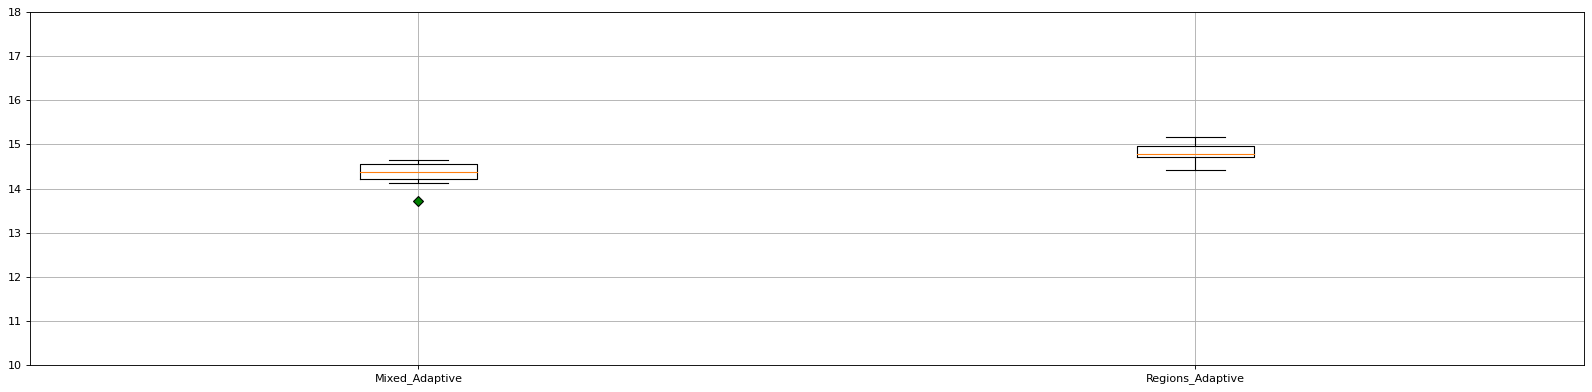

In [23]:
simple_boxplot(mean_active_areas_dict, "REAL_adaptiveTimeout_meanActiveAreas", True)